<a href="https://colab.research.google.com/github/aminsarzaeem/deep/blob/main/hw4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VQ-VAE**
There are several reasons why VQ-VAE is considered to be an improvement over conventional VAE:

Improved data compression: VQ-VAE replaces the continuous latent variables used in conventional VAE with discrete latent variables. This allows for more efficient data compression, as discrete codes can represent data more compactly.

Disentangled representations: Conventional VAEs often struggle to learn disentangled representations of data features. In VQ-VAE, the discrete latent variables force the model to learn distinct and interpretable codes for different data features, leading to more disentangled representations.

Improved training stability: VQ-VAE addresses the common issue in conventional VAEs known as posterior collapse, where the model ignores the latent code and only focuses on the reconstruction. By introducing the vector quantization mechanism, VQ-VAE encourages the model to utilize the codebook effectively, avoiding posterior collapse and ensuring better training stability.

Scalability: VQ-VAE can scale more effectively to larger datasets and more complex models. The discrete nature of the latent codes simplifies the model, making it easier to train and apply to larger datasets.

Better generative modeling: VQ-VAE shows improved sample quality and diversity compared to conventional VAEs. The discrete codes learned by VQ-VAE allow for more structured and interpretable generation of data.

Overall, vector quantized VAE offers several advantages over conventional VAE in terms of data compression, representation learning, training stability, scalability, and generative modeling. However, the choice between the two depends on the specific requirements and constraints of the problem at hand.

# B
loading test and train mnist dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 77512106.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46590651.47it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 33334416.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17558091.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# C

defining three function
encoding
decoding
vector quantizing
and model class using these 3 function.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        #print(inputs.shape)
        #inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings ,self._embedding.weight
        return loss, quantized.contiguous(), perplexity, encodings ,self._embedding.weight

class Encoder(nn.Module):
    def __init__(self, z_dim, num_embedding):
        super(Encoder, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1))
        #self.conv3 = spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1))
        #self.conv4 = spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0))
        self.fc = spectral_norm(nn.Linear(128, z_dim))
        #self.embedding = nn.Embedding(num_embedding, z_dim)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        #x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #z = self.embedding.weight
        #z = F.normalize(z, dim=1)
        return x #, z


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.fc = spectral_norm(nn.Linear(z_dim, 128))
        self.deconv1 = spectral_norm(nn.ConvTranspose2d(128, 64, kernel_size=7, stride=1, padding=0))
        #self.deconv1 = spectral_norm(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1))
        #self.deconv2 = spectral_norm(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1))
        self.deconv3 = spectral_norm(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1))
        self.deconv4 = spectral_norm(nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1))

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 128, 1, 1)
        x = F.relu(self.deconv1(x))
        #x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.tanh(self.deconv4(x))
        return x


class VQVAE(nn.Module):
    def __init__(self, z_dim, num_embedding):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(z_dim, num_embedding)
        self._vq_vae = VectorQuantizer(num_embedding, z_dim, commitment_cost=1)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        loss, z_q, perplexity, encodings , codes= self._vq_vae(z_e)
        x_hat = self.decoder(z_q)
        return loss, x_hat, perplexity, z_e, z_q , codes




In [96]:
# create a model
batch_size = 64
commitment_cost = 0.25
learning_rate = 0.01
num_epochs=5
z_dim = 2
num_embedding = 3
model = VQVAE(z_dim, num_embedding)

In [57]:
if(torch.cuda.is_available()):
      device = 'cuda'
else:
      device = 'cpu'
print(device)

cuda


# D
**training model by given loss func**

In [97]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
model.train()
train_res_recon_error = []
train_res_perplexity = []
losshist=[]
model.to(device)
for epoch in range(num_epochs):
  print()
  print(50 * "#")
  total_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity ,z_e, z_q, codes= model(data)
    recon_error = F.mse_loss(data_recon, data) /64
    loss = recon_error + vq_loss
    loss.backward()
    optimizer.step()
    losshist.append(loss.item())
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (batch_idx+1) % 400 == 0:
        print('%d iterations' % (batch_idx+1))
        print('total loss: %.3f' % np.mean(losshist[-400:]))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-400:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-400:]))


##################################################
400 iterations
total loss: 0.174
recon_error: 0.001
perplexity: 1.000
800 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000

##################################################
400 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000
800 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000

##################################################
400 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000
800 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000

##################################################
400 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000
800 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000

##################################################
400 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000
800 iterations
total loss: 0.001
recon_error: 0.001
perplexity: 1.000


# E

**ploting LOSS function during the training**

Text(0.5, 0, 'iteration')

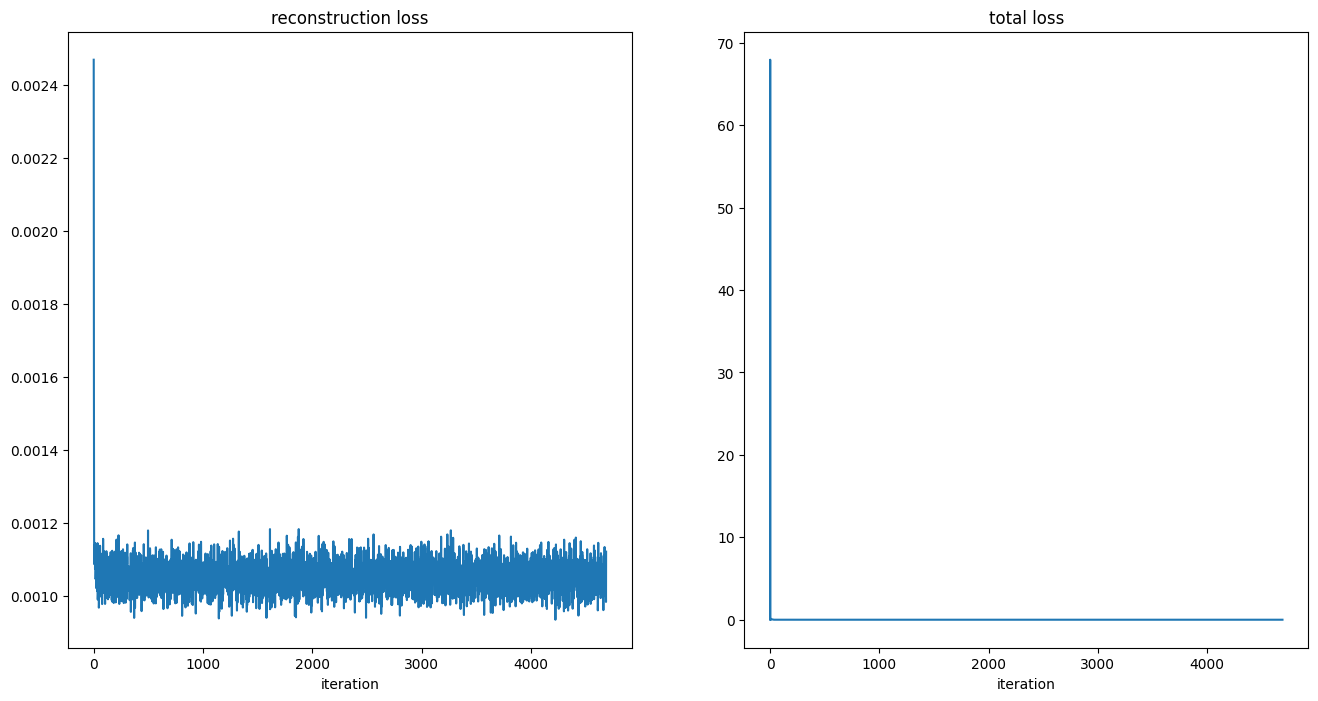

In [98]:
#train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
#train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
#ax.set_yscale('log')
ax.set_title('reconstruction loss')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(losshist)
ax.set_title('total loss')
ax.set_xlabel('iteration')

**ploting code book**

there are 3 possible codes in 2d latent space. each input quantized to one of the.

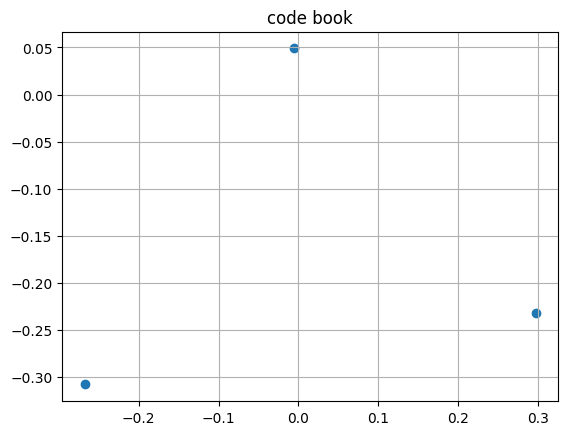

In [99]:
x=(codes.detach().cpu()).numpy()
plt.figure()
plt.scatter(x[:,0],x[:,1])
plt.title('code book')
plt.grid()
plt.show()

**reconstruction of test dataset**

In [103]:
model.eval()
(data, _) =next(iter(train_loader))
loss, x_hat, perplexity, z_e, z_q , codes=model(data.to(device))

In [104]:
Xhat=(x_hat.detach().cpu()).numpy()
latent=(z_e.detach().cpu()).numpy()
input=data.numpy()

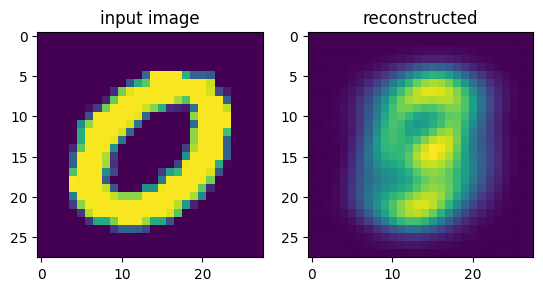

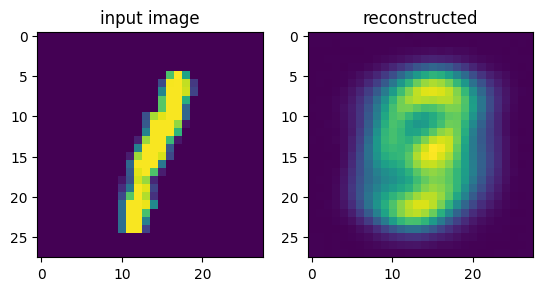

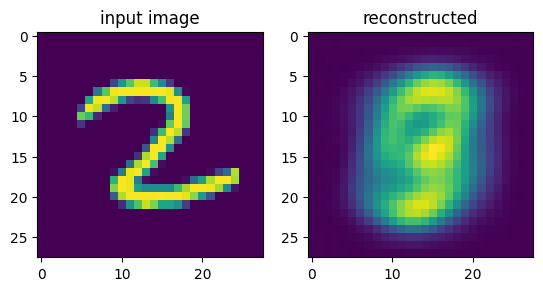

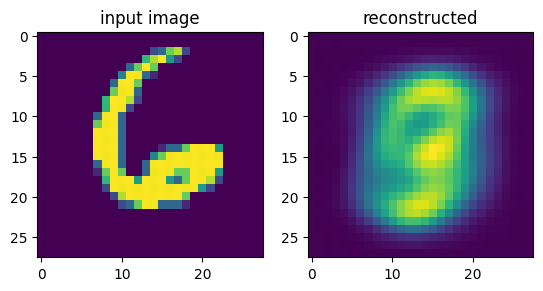

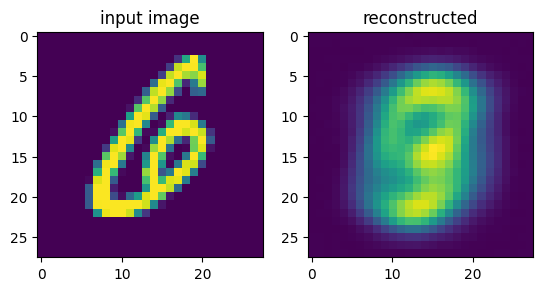

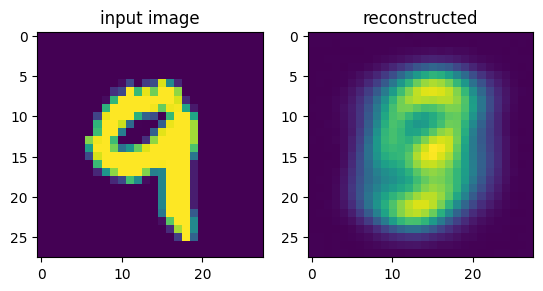

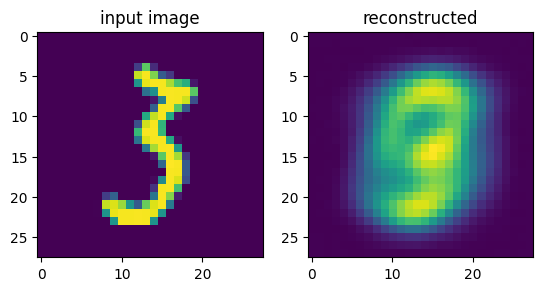

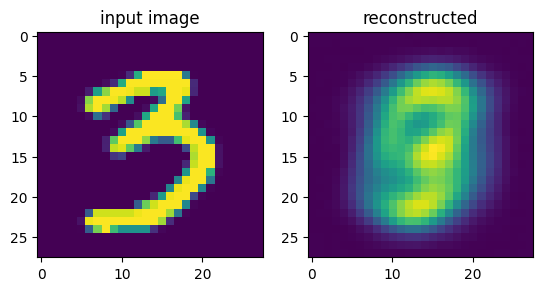

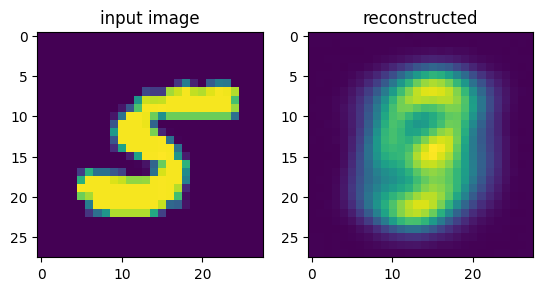

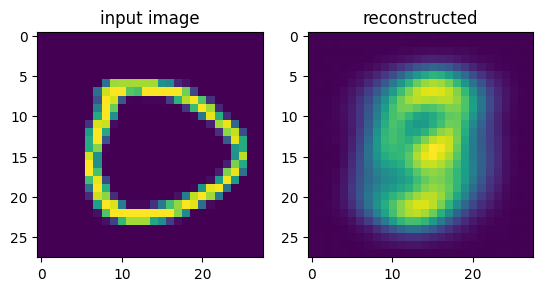

In [107]:
for i in range(10):
  f = plt.figure()
  ax = f.add_subplot(1,2,1)
  ax.imshow(input[i,0])
#ax.set_yscale('log')
  ax.set_title('input image')


  ax = f.add_subplot(1,2,2)
  ax.imshow(Xhat[i,0])
  ax.set_title('reconstructed')


the plot below shows the model latent space output for one batch. the plot below shows that the encoder is not well-trained and all inputs encode around one point in the latent space.

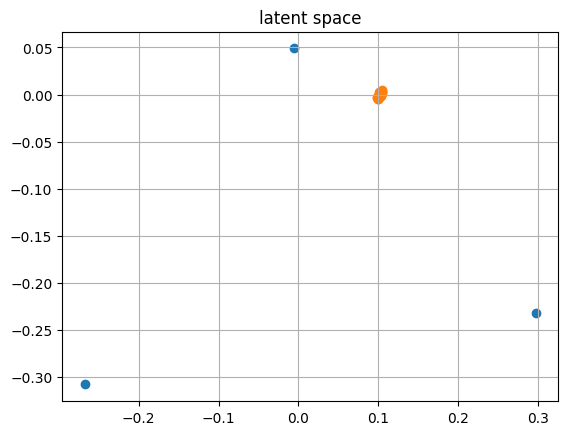

In [101]:
plt.figure()
plt.scatter(x[:,0],x[:,1])
plt.title('latent space')
plt.grid()
plt.scatter(latent[:,0],latent[:,1])
plt.show()